This notebook demonstrates how to leverage transfer learning to use your own image dataset to build and train an image classification model using MXNet and Amazon SageMaker.

---
1. [Prerequisites](#Prerequisites)
1. [Download Data](#Download-data)
1. [Fine-tuning the Image Classification Model](#Fine-tuning-the-Image-classification-model)
1. [Start the Training](#Start-the-training)
1. [Test your Model](#Inference)
1. [Deploy your Model to AWS DeepLens](#Deploy)

## Prequisites

- Amazon Sagemaker notebook should have internet access to download images needed for testing this notebook. This is turned ON by default. To explore another options review this link : [Sagemaker routing options](https://aws.amazon.com/blogs/machine-learning/understanding-amazon-sagemaker-notebook-instance-networking-configurations-and-advanced-routing-options/)
- The IAM role assigned to this notebook should have permissions to create a bucket (if it does not exist)
  - [IAM role for Amazon Sagemaker](https://docs.aws.amazon.com/glue/latest/dg/create-an-iam-role-sagemaker-notebook.html)
  - [S3 create bucket permissions](https://docs.aws.amazon.com/AmazonS3/latest/dev/using-with-s3-actions.html#using-with-s3-actions-related-to-buckets)

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are 2 parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
import os
import urllib.request
import boto3, botocore

import sagemaker
from sagemaker import get_execution_role

import mxnet as mx
mxnet_path = mx.__file__[ : mx.__file__.rfind('/')]
print(f"mxnet_path: {mxnet_path}")

role = get_execution_role()
print(f"aws iam role: {role}")

sess = sagemaker.Session()

mxnet_path: /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet
aws iam role: arn:aws:iam::677092314568:role/service-role/AmazonSageMaker-ExecutionRole-20210806T182472


## Amazon S3 bucket info
Enter your Amazon S3 Bucket name where your data will be stored, make sure that your SageMaker notebook has access to this S3 Bucket by granting `S3FullAccess` in the SageMaker role attached to this instance. See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-config-permissions.html) for more info.

DeepLens-compatible buckets must start with `deeplens`

In [2]:
# --> Bucket Exist and have permisions
BUCKET = 'deeplens-sampleproject-677092314568'

# --> Bucket doesn't exists
#BUCKET = 'deeplens-sampleproject-6770923145689'

# --> Bucket exists and doesn't have permisions
#BUCKET = 'ecommerce-terraforms'


PREFIX = 'deeplens-trash-test'

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print(f"training_image: {training_image}")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


training_image: 811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


We are going to check if we have the right bucket and if we have the right permissions.

Please make sure that the result from this cell is "Bucket access is Ok"

In [4]:
test_data = 'TestData'
s3 = boto3.resource('s3')
object = s3.Object(BUCKET, PREFIX+"/text.txt")

try:
    object.put(Body=test_data)
except botocore.exceptions.ClientError as e:
    print(e.response)
    if e.response['Error']['Code'] == 'AccessDenied':
        #cannot write on the bucket
        print(f"Bucket {BUCKET} is not writeble, make sure you have the right permissions")
    else:
        if e.response['Error']['Code'] == 'NoSuchBucket':
            #Bucket does not exist
            print(f"Bucket {BUCKET} does not exist")
        else:
            print("Shomething went wrong and I don't know what and/or why")
            raise
    
else:
    print("Bucket access is Ok")
    object.delete()

Bucket access is Ok


# Prepare data

It is assumed that your custom dataset's images are present in an S3 bucket and that different classes are separated by named folders, as shown in the following directory structure:
```
|-deeplens-bucket
   |-deeplens-trash

    |-images
    
        |-Compost 
    
        |-Landfill
    
        |-Recycle
 ```

In [5]:
!wget https://deeplens-public.s3.amazonaws.com/samples/deeplens-trash/trash-images.zip

--2021-08-09 17:12:22--  https://deeplens-public.s3.amazonaws.com/samples/deeplens-trash/trash-images.zip
Resolving deeplens-public.s3.amazonaws.com (deeplens-public.s3.amazonaws.com)... 52.216.242.140
Connecting to deeplens-public.s3.amazonaws.com (deeplens-public.s3.amazonaws.com)|52.216.242.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253515836 (242M) [application/zip]
Saving to: ‘trash-images.zip’

trash-images.zip    100%[===================>] 241.77M  76.4MB/s    in 3.2s    

2021-08-09 17:12:25 (76.4 MB/s) - ‘trash-images.zip’ saved [253515836/253515836]



In [6]:
!pwd

/home/ec2-user/SageMaker/deeplens-sampleproject


In [7]:
!ls -l

total 247588
-rw-rw-r-- 1 ec2-user ec2-user      8589 Aug  9 17:12 aws-deeplens-custom-trash-detector.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 253515836 Mar 10  2020 trash-images.zip


In [8]:
!rm -rf data/ && mkdir -p data/images
!unzip -qq trash-images.zip -d data/images
!rm trash-images.zip
!ls -l

total 16
-rw-rw-r-- 1 ec2-user ec2-user 8589 Aug  9 17:12 aws-deeplens-custom-trash-detector.ipynb
drwxrwxr-x 3 ec2-user ec2-user 4096 Aug  9 17:12 data


In [9]:
!ls data/images

Compost  Landfill  Recycling


In [10]:
!ls -al data/images/

total 36
drwxrwxr-x 5 ec2-user ec2-user  4096 Aug  9 17:12 .
drwxrwxr-x 3 ec2-user ec2-user  4096 Aug  9 17:12 ..
drwxr-xr-x 2 ec2-user ec2-user 12288 Feb 24  2020 Compost
drwxr-xr-x 2 ec2-user ec2-user 12288 Feb 24  2020 Landfill
drwxr-xr-x 2 ec2-user ec2-user  4096 Feb 24  2020 Recycling


In [11]:
!ls -l data/images/Compost/ data/images/Landfill/ data/images/Recycling/

data/images/Compost/:
total 101052
-rw-r--r-- 1 ec2-user ec2-user 509529 Jul 29  2018 20180403-195616.jpg
-rw-r--r-- 1 ec2-user ec2-user 485929 Jul 29  2018 20180403-195643.jpg
-rw-r--r-- 1 ec2-user ec2-user 515320 Jul 29  2018 20180403-195651.jpg
-rw-r--r-- 1 ec2-user ec2-user 520909 Jul 29  2018 20180403-195701.jpg
-rw-r--r-- 1 ec2-user ec2-user 513095 Jul 29  2018 20180403-195711.jpg
-rw-r--r-- 1 ec2-user ec2-user 487846 Jul 29  2018 20180403-195729.jpg
-rw-r--r-- 1 ec2-user ec2-user 504845 Jul 29  2018 20180403-195736.jpg
-rw-r--r-- 1 ec2-user ec2-user 505385 Jul 29  2018 20180403-195746.jpg
-rw-r--r-- 1 ec2-user ec2-user 507942 Jul 29  2018 20180403-195757.jpg
-rw-r--r-- 1 ec2-user ec2-user 505568 Jul 29  2018 20180403-195810.jpg
-rw-r--r-- 1 ec2-user ec2-user 412947 Jul 29  2018 20180403-195833.jpg
-rw-r--r-- 1 ec2-user ec2-user 417571 Jul 29  2018 20180403-195840.jpg
-rw-r--r-- 1 ec2-user ec2-user 496045 Jul 29  2018 20180403-195848.jpg
-rw-r--r-- 1 ec2-user ec2-user 468145 Jul 

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(item_name, images_to_show=-1):
    _im_list = !ls $IMAGES_DIR/$item_name
    
    NUM_COLS = 3
    if images_to_show == -1:
        IM_COUNT = len(_im_list)
    else:
        IM_COUNT = images_to_show
        
    print("Display images category " + item_name + str(IM_COUNT) + " images.")
    
    NUM_ROWS = int(IM_COUNT / NUM_COLS)
    if ((IM_COUNT % NUM_COLS) > 0):
        NUM_ROWS += 1
        
    fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS)
    fig.set_size_inches(10.0, 10.0, forward=True)
    
    curr_row = 0
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        f = IMAGES_DIR + item_name + "/" + _im_list[curr_img]
        a = plt.imread(f)
        
        # find the column by taking the current index modulo 3
        col = curr_img % NUM_ROWS
        # plot on relevant subplot
        if NUM_ROWS == 1:
            axarr[curr_row].imshow(a)
        else:
            axarr[col, curr_row].imshow(a)
        if col == (NUM_ROWS -1):
            # We have finished the current row, so increment row counter
            curr_row += 1
            
    fig.tight_layout()
    plt.show()
    
    # Clean up
    plt.clf()
    plt.cla()
    plt.close()

In [46]:
# _im_list = !ls $IMAGES_DIR/$item_name
_im_list = !ls data/images/Compost

In [47]:
len(_im_list)

219

Display images category Compost3 images.


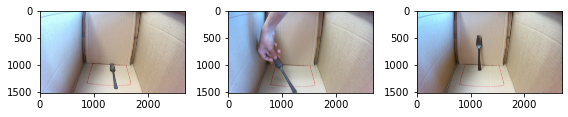

Display images category Landfill3 images.


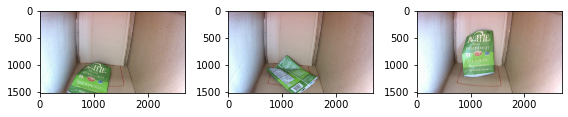

Display images category Recycling3 images.


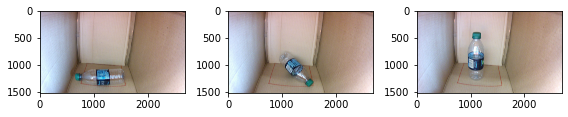

In [49]:
IMAGES_DIR = 'data/images/'
show_images("Compost", images_to_show=3)
show_images("Landfill", images_to_show=3)
show_images("Recycling", images_to_show=3)

In [52]:
DEST_BUCKET = 's3://'+BUCKET+'/images/'

In [53]:
DEST_BUCKET

's3://deeplens-sampleproject-677092314568/images/'

In [54]:
!aws s3 cp --recursive data/images $DEST_BUCKET --quiet

Ensure that the newly created directories containing the downloaded data are structured as shown at the beginning of this tutorial.

In [57]:
!aws s3 ls $DEST_BUCKET

                           PRE Compost/
                           PRE Landfill/
                           PRE Recycling/


#### Prepare "list" files with train-val split

The image classification algorithm can take two types of input formats. The first is a [RecordIO format](https://mxnet.apache.org/api/faq/recordio) (content type: application/x-recordio) and the other is a Image list format (.lst file). These file formats allows for efficient loading of images when training the model. In this example we will be using the Image list format (.lst file). A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The RecordIO file contains the actual pixel data for the images.

To be able to create the .rec files, we first need to split the data into training and validation sets (after shuffling) and create two list files for each. Here our split into train, validation and test (specified by the `0.7` parameter below for test). We keep 0.02% to test the model.

The image and lst files will be converted to RecordIO file internally by the image classification algorithm. But if you want do the conversion, the following cell shows how to do it using the [im2rec](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) tool. Note that this is just an example of creating RecordIO files. We are **_not_** using them for training in this notebook.